In [2]:
from biblio import *
from time import perf_counter as tpc

In [3]:
# Data loading
r_data, q_data = np.loadtxt('q_structure.txt', comments='%', unpack=True)
q_data *= 0.5  # Scale the source term

# Interpolate q(r) for use on the grid
q_interp = e.interp1d(r_data, q_data, fill_value="linear")

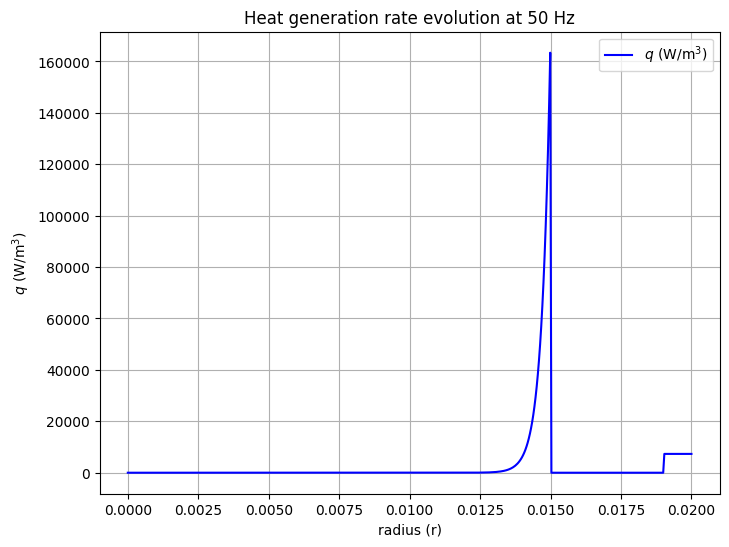

In [6]:
# Unit test merci louis =)

x_min = 0
x_max = 0.02
num_points = 500

# Générer des points d'échantillonnage
x_dense = np.linspace(x_min, x_max, num_points)
y_dense = q_interp(x_dense)
   
# Tracer la fonction
plt.figure(figsize=(8, 6))
plt.plot(x_dense, y_dense, label=r"$q \ (\text{W/m}^3)$", color="blue")
plt.title("Heat generation rate evolution at 50 Hz")
plt.xlabel("radius (r)")
plt.ylabel(r"$q \ (\text{W/m}^3)$")
plt.legend()
plt.grid()
plt.show()

# 1. Case Study <a class="anchor" id="1"></a>

## 1.1 General Condition <a class="anchor" id="1.1"></a>

<div style="text-align: center;">
    <img src="Figure/Figure1.png" style="max-width: 850px; display: inline;" alt="Studied Network" />
</div>


In [9]:
########################################################################
#                       constants values
########################################################################

k_core = 44.5       # W/m·K
k_air = 0.05        # W/m·K
k_coil = 400        # W/m·K

cp_core = 450.0       # J/m³·K
cp_air = 1006.0       # J/m³·K
cp_coil = 385.0       # J/m³·K

rho_core = 7860.0     # kg/m³
rho_air = 1.1839    # kg/m³
rho_coil = 8940.0     # kg/m³

T_amb = 20          # °C
h_air = 20          # W/m²·K

nodes_core = 2049 # number of nodes for core magnetic side (2^m + 1), with m an interger
nodes_air = 512 # number of nodes for core magnetic side (2^p), with p an interger
nodes_coil = 128 # number of nodes for core magnetic side (2^q), with q an interger

n_tot = nodes_core + nodes_air + nodes_coil # notal number of nodes

length_core = 0.015 # thinkness of core magnetic part
length_air = 0.004 # thinkness of air part
length_coil = 0.001 # thinkness of coil part

total_length = length_core + length_air + length_coil # total length (in radial direction)

# Generate non-uniform mesh
r_core = np.linspace(0, length_core, nodes_core, endpoint=False)
r_air = np.linspace(length_core, length_core + length_air, nodes_air, endpoint=False)
r_coil = np.linspace(length_core + length_air, total_length, nodes_coil)
r = np.concatenate([r_core, r_air, r_coil])

k = np.zeros(n_tot) # matrix used to store every thermal conductivity

# Assign thermal conductivity per material
k[:nodes_core] = k_core
k[nodes_core:nodes_core+nodes_air] = k_air
k[nodes_core+nodes_air:n_tot] = k_coil

# Assign heat capacity per material
cp = np.zeros(n_tot) # matrix used to store every thermal conductivity

cp[:nodes_core] = cp_core
cp[nodes_core:nodes_core+nodes_air] = cp_air
cp[nodes_core+nodes_air:n_tot] = cp_coil

# Assign heat capacity per material
rho = np.zeros(n_tot) # matrix used to store every thermal conductivity

rho[:nodes_core] = rho_core
rho[nodes_core:nodes_core+nodes_air] = rho_air
rho[nodes_core+nodes_air:n_tot] = rho_coil

## 1.3 Unsteady State <a class="anchor" id="1.1"></a>

<div style="text-align: center;">
    <img src="Figure/Figure3.png" style="max-width: 850px; display: inline;" alt="Studied Network" />
</div>

In [23]:
# Weighted method - Crank-Nicolson method

# Interpolated source term
q = q_interp(r)

# Time step

# Total duration
total_duration = 100000

# Time step
dt = 1000

# Number of time steps
n_time = int(total_duration/dt)

# Theta 

theta = 1

T = np.full((n_time, n_tot), 20.0)
b = np.zeros((n_time, n_tot))
A = np.zeros((n_tot,n_tot))

A_temp = np.zeros(n_tot)
T_temp = np.full(n_tot, T_amb)
b_temp = np.zeros(n_tot)

#####################################################
# Neumman boundary condition dT/dr = 0 (no flux term)
#####################################################

##########################################################################
# Compute average radius i.e. r_(i+1/2) or r_(i-1/2)
# And also average heat conductivity i.e. r_(i+1/2) or r_(i-1/2)
##########################################################################

r0_plus_half = return_moy(r[0], r[1])

k0_plus_half = k[0]

cp0_plus_half = cp[0]

rh0_plus_half = rho[0]

dr_0_plus_one = r[1] - r[0]

S0_plus_half = return_surface(r0_plus_half)

V0 = return_volume(r0_plus_half, r[0]) # half volume considered

########################################################################################

#####################################################
# Fourier boundary condition -k(dT/dr) = h(T_f - T_n) 
#   with T_f, the ambiant air temperature
#   with h the convection air coefficient
#####################################################

##########################################################################
# Compute average radius i.e. r_(i-1/2)
# And also average heat conductivity i.e. k_(i-1/2)
##########################################################################

r_not_minus_half = return_moy(r[n_tot-2], r[n_tot-1])

ki_not_minus_half = k[n_tot-1]

cpi_not_minus_half = cp[n_tot-1]

rhoi_not_minus_half = rho[n_tot-1]

##########################################################################
# Compute the 2 surface area to compute :
# S_i and S_{i-1/2}
##########################################################################

S_ntot_1 = return_surface(r[n_tot-1])  # Surface area for convection at the last node (outermost radius)
S_ntot_minus_half = return_surface(r_not_minus_half)  # Surface area for conduction between second-to-last and last node

##########################################################################
# Compute the volume : V_i 
##########################################################################

V_ntot = return_volume(r[n_tot-1], r_not_minus_half) # half of a volume is considered

##########################################################################
# Compute the three coefficient i.e. a_{i,i} and a_{i,i-1} 
# Compute also the source term coefficient i.e. b_{i}
##########################################################################

# Applying the Fourier boundary condition at the last node
dr_last = r[n_tot - 1] - r[n_tot - 2]  # Radial step for the last node

running_time = tpc()

for t in range(1, n_time):
    current_time_in_seconds = tpc()
    #####################################################
    # Neumman boundary condition dT/dr = 0 (no flux term)
    #####################################################

    A[0,1] = - theta * ( k0_plus_half / dr_0_plus_one ) * S0_plus_half
    A[0,0] = ((rh0_plus_half * cp0_plus_half * V0) / dt) - A[0,1]
    
    temp_1_bound_1 = q[0] * V0  
    temp_2_bound_1 = ((1 - theta) * ( k0_plus_half * T[t-1][1] / dr_0_plus_one)) * S0_plus_half  
    temp_3_bound_1 = ((1 - theta) * ( k0_plus_half * T[t-1][0] / dr_0_plus_one)) * S0_plus_half 
    temp_4_bound_1 = ((rh0_plus_half * cp0_plus_half * V0 * T[t-1][0]) / dt) 
    
    b[t][0] = temp_1_bound_1 + temp_2_bound_1 - temp_3_bound_1 + temp_4_bound_1
    
    #####################################################
    # Fourier boundary condition -k(dT/dr) = h(T_f - T_n) 
    #   with T_f, the ambiant air temperature
    #   with h the convection air coefficient
    #####################################################

    A[n_tot - 1,n_tot - 2] = - theta * ( ki_not_minus_half / dr_last) * S_ntot_minus_half
    A[n_tot - 1,n_tot - 1] = (rhoi_not_minus_half * cpi_not_minus_half * V_ntot / dt) - A[n_tot - 1, n_tot - 2] + theta * h_air * S_ntot_1
    
    temp_1_bound_2 = q[n_tot - 1] * V_ntot  
    temp_2_bound_2 = ((1 - theta) * ( ki_not_minus_half * T[t-1][n_tot - 2] / dr_last)) * S_ntot_minus_half 
    temp_3_bound_2 = ((1 - theta) * (h_air * (T[t-1][n_tot - 1] - T_amb)))  * S_ntot_1 
    temp_4_bound_2 = ((1 - theta) * ( ki_not_minus_half * T[t-1][n_tot - 1] / dr_last)) * S_ntot_minus_half  
    temp_5_bound_2 = ((rhoi_not_minus_half * cpi_not_minus_half * V_ntot * T[t-1][n_tot - 1]) / dt)
    temp_6_bound_2 = theta * h_air * T_amb * S_ntot_1
      
    b[t][n_tot - 1] = temp_1_bound_2 + temp_2_bound_2 - temp_3_bound_2 - temp_4_bound_2 + temp_5_bound_2 + temp_6_bound_2
    
    for i in range (1, n_tot-1):
        
        ##########################################################################
        # Compute average radius i.e. r_(i+1/2) or r_(i-1/2)
        # And also average heat conductivity i.e. k_(i+1/2) or k_(i-1/2)
        # And also average heat capacity i.e. cp_(i+1/2) or cp_(i-1/2)
        # And also average density i.e. rho_(i+1/2) or rho_(i-1/2)
        ##########################################################################
        
        ri_plus_half = return_moy(r[i], r[i+1])    
        ri_minus_half = return_moy(r[i-1], r[i])
        
        ki_plus_half = k[i+1] 
        ki_minus_half = k[i]
        
        cpi_plus_half = cp[i+1]
        cpi_minus_half = cp[i]

        rhoi_plus_half = rho[i+1]
        rhoi_minus_half = rho[i]
        
        ######################################################################################
        # Compute the radial step (difference in radius) for neighboring nodes
        # dr_minus_one = r[i] - r[i-1] corresponds to the radial step between node i and i-1
        # dr_plus_one = r[i+1] - r[i] corresponds to the radial step between node i and i+1
        ######################################################################################

        dr_minus_one = r[i] - r[i-1]
        dr_plus_one = r[i+1] - r[i]
        
        ############################################################################################################
        # Compute the surface areas at the average radii:
        # Si_plus_half corresponds to the surface area at the average radius (r_(i+1/2)) between nodes i and i+1.
        # Si_minus_half corresponds to the surface area at the average radius (r_(i-1/2)) between nodes i-1 and i.
        ############################################################################################################

        Si_plus_half = return_surface(ri_plus_half)
        Si_minus_half = return_surface(ri_minus_half)

        ############################################################################################################
        # Compute the volumes at the average radii:
        # Vi corresponds to the volume between the average radii r_(i-1/2) and r_(i+1/2).
        ############################################################################################################

        Vi = return_volume(ri_plus_half, ri_minus_half)
        Vi_minus_half = return_volume(r[i], ri_minus_half)
        Vi_plus_half = return_volume(ri_plus_half, r[i])
        
        rhoi = (rhoi_minus_half * Vi_minus_half + rhoi_plus_half * Vi_plus_half) / (Vi_minus_half + Vi_plus_half)
        cpi = (cpi_minus_half * Vi_minus_half + cpi_plus_half * Vi_plus_half) / (Vi_minus_half + Vi_plus_half)
            
        ##########################################################################
        # Compute also the source term coefficient i.e. b_{i}
        ##########################################################################
        
        A[i,i-1] = - theta * ( ki_minus_half / dr_minus_one) * Si_minus_half
        A[i,i+1] = - theta * ( ki_plus_half / dr_plus_one ) * Si_plus_half
        A[i,i] = ((rhoi * cpi * Vi) / dt) - A[i,i-1] - A[i,i+1]
        
        term1 = q[i] * Vi
        term2 = ((1 - theta) * ( ki_minus_half * T[t-1][i-1] / dr_minus_one)) * Si_minus_half
        term3 = ((1 - theta) * ( ki_plus_half * T[t-1][i+1] / dr_plus_one)) * Si_plus_half
        term4 = ((1 - theta) * ( ki_minus_half * T[t-1][i] / dr_minus_one)) * Si_minus_half 
        term5 = ((1 - theta) * ( ki_plus_half * T[t-1][i] / dr_plus_one)) * Si_plus_half 
        term6 = ((rhoi * cpi * Vi * T[t-1][i]) / dt)
        
        b[t][i] = term1 + term2 + term3 - term4 - term5 + term6
    
    A_temp = A.copy()
    b_temp = b[t][:].copy()
    T[t][:] = np.linalg.solve(A, b[t][:])
    print("Current time in seconds:", tpc() - current_time_in_seconds)
    print(np.max(T[t][:]))

print("Current time in seconds:", tpc() - running_time)

Current time in seconds: 0.17279308300931007
21.45364249421588
Current time in seconds: 0.1802419580053538
22.54067648602025
Current time in seconds: 0.16174354101531208
23.352222320603357
Current time in seconds: 0.14955662505235523
23.957757863887498
Current time in seconds: 0.1499182500410825
24.409545194349057
Current time in seconds: 0.16975916689261794
24.74661836549438
Current time in seconds: 0.14950537506956607
24.998104306243327
Current time in seconds: 0.1481043330859393
25.185734676314258
Current time in seconds: 0.13601516606286168
25.3257232160277
Current time in seconds: 0.15919679193757474
25.430166807106797
Current time in seconds: 0.14873145904857665
25.508090774721285
Current time in seconds: 0.14998233306687325
25.56622879910769
Current time in seconds: 0.200803208979778
25.609604793615315
Current time in seconds: 0.16001095797400922
25.641967032470355
Current time in seconds: 0.14504862495232373
25.66611205681152
Current time in seconds: 0.14598220807965845
25.6841

Figure saved as Figure/Temperature_vs_radius_unsteady.png


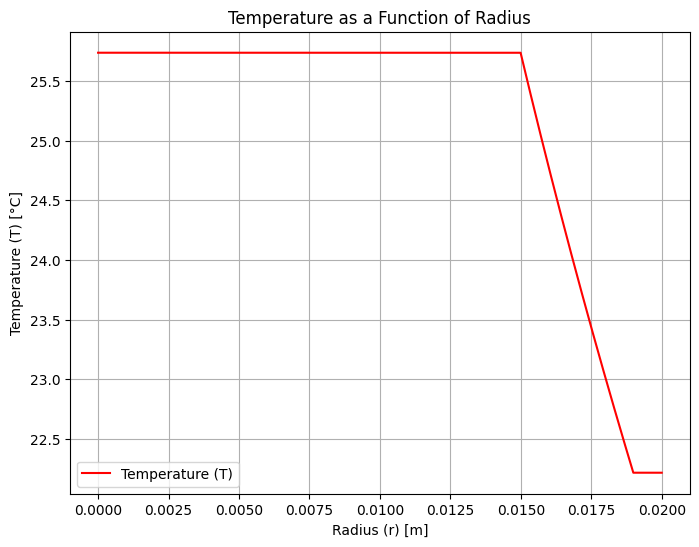

Figure saved as Figure/heat_map_temperature_unsteady.png


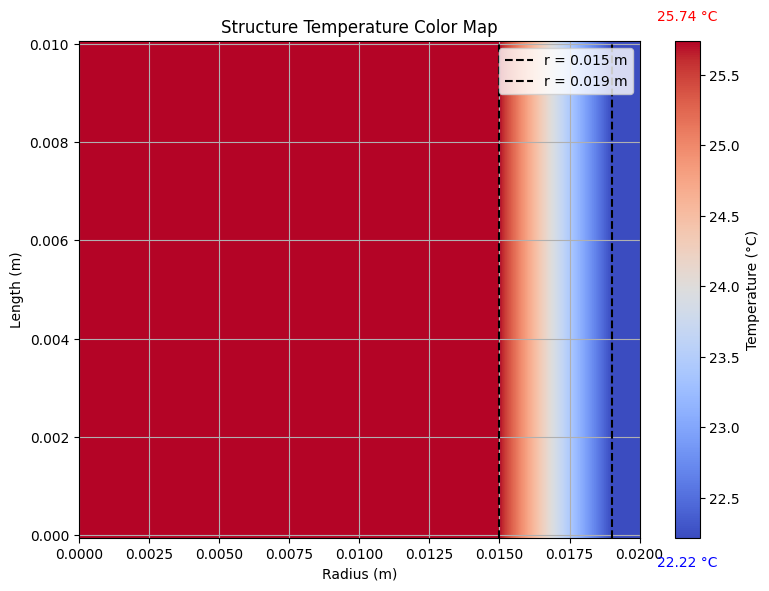

In [24]:
plot_temperature_vs_radius(r, T[n_time - 1][:], save_path="Figure/Temperature_vs_radius_unsteady.png")
plot_temperature_map(r, T[n_time - 1][:], save_path="Figure/heat_map_temperature_unsteady.png")